In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from deepymod_torch.library_function import library_1D_in
from deepymod_torch.neural_net import deepmod_init, train

try:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')  # enable for GPU
except:
    pass


#%% Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
data = np.load('data/processed/burgers.npy', allow_pickle=True).item()

In [3]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))

print(X.shape, y.shape)

(25856, 2) (25856, 1)


In [4]:
noise_level = 0.25
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

In [5]:
number_of_samples = 1000

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

In [7]:
optim_config = {'lambda': 10**-5, 'max_iterations': 20000}
network_config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 5, 'output_dim': 1}
library_config = {'type': library_1D_in, 'poly_order': 2, 'diff_order': 2}

In [8]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)
time_deriv_list, theta, coeff_vector_list = train(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 2.0E+00 8.1E-02 1.9E+00 1.3E-02
tensor([[-1.3764],
        [-0.5860],
        [ 0.0993],
        [ 0.0393],
        [ 1.1484],
        [-0.2577],
        [-0.1894],
        [-0.0037],
        [-1.7295]], requires_grad=True)
500 1.7E-01 1.2E-01 5.3E-02 1.2E-04
tensor([[-0.8180],
        [-1.3032],
        [ 0.5077],
        [ 0.8928],
        [ 1.4966],
        [-1.0501],
        [ 0.5603],
        [-0.6519],
        [-2.4926]], requires_grad=True)
1000 5.9E-02 4.6E-02 1.4E-02 1.3E-04
tensor([[-0.5263],
        [-1.4761],
        [ 0.5361],
        [ 1.2344],
        [ 1.5825],
        [-1.1920],
        [ 0.7059],
        [-0.6853],
        [-2.5626]], requires_grad=True)
1500 3.4E-02 2.7E-02 7.1E-03 1.3E-04
tensor([[-0.3365],
        [-1.5661],
        [ 0.5910],
        [ 1.3476],
        [ 1.6691],
        [-1.1682],
        [ 0.7293],
        [-0.6830],
        [-2.5392]], requires_grad=True)
2000 2.7E-02 2.0E-02 6.6E-03 1.6E-04
tensor([[-0.232

In [12]:
c_inferred_deepmod = network(torch.tensor(X, dtype=torch.float32)).reshape(data['x'].shape).detach().cpu().numpy()

now let's try it with a normal network:

In [13]:
network_MSE = deepmod_init(network_config, library_config)[0]
optimizer = torch.optim.Adam([{'params': network_MSE.parameters(), 'lr': 0.002}])
max_iterations = 20000

In [14]:
for iteration in np.arange(max_iterations):
    prediction = network_MSE(X_train)
    loss = torch.mean((prediction - y_train)**2)
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
            
    if iteration % 1000 == 0:
        print(iteration, loss.item())

0 0.04426572471857071
1000 0.001981872832402587
2000 0.0019115458708256483
3000 0.001889391103759408
4000 0.0018731887685135007
5000 0.0018576805014163256
6000 0.001846631639637053
7000 0.001837736228480935
8000 0.0018300212686881423
9000 0.001820864505134523
10000 0.001800038036890328
11000 0.0017825120594352484
12000 0.0017624474130570889
13000 0.0017337758326902986
14000 0.001695124665275216
15000 0.0016437311423942447
16000 0.0015969846863299608
17000 0.0015697209164500237
18000 0.0014671818353235722
19000 0.001410367782227695


In [15]:
c_inferred_MSE = network_MSE(torch.tensor(X, dtype=torch.float32)).reshape(data['x'].shape).detach().cpu().numpy()

In [16]:
plt.style.use('seaborn-paper')

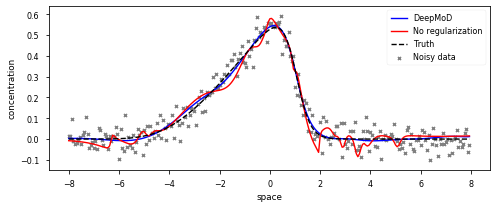

In [47]:
frame = 50
factor = 1

plt.figure(figsize=(7*factor, 3*factor))
plt.scatter(data['x'][:, frame], y_noisy.reshape(data['u'].shape)[:, frame], marker='x', c='grey', s=10, linewidths=0.1 ,label='Noisy data')
plt.plot(data['x'][:, frame], c_inferred_deepmod[:, frame], 'b', label='DeepMoD')
plt.plot(data['x'][:, frame], c_inferred_MSE[:, frame], 'r', label='No regularization')
plt.plot(data['x'][:, frame], np.real(data['u'])[:, frame], 'k--', label='Truth')

plt.legend()

plt.xlabel('space')
plt.ylabel('concentration')

plt.tight_layout()
plt.savefig('DeepMoD_vs_MSE.pdf', bbox_inches='tight')

In [98]:
used_idx = np.where(X[idx, 0][:number_of_samples] ==data['t'][0, frame])[0]

In [101]:
c_used = y_noisy[idx][:number_of_samples][used_idx]
x_used = X[idx, 1][:number_of_samples][used_idx]

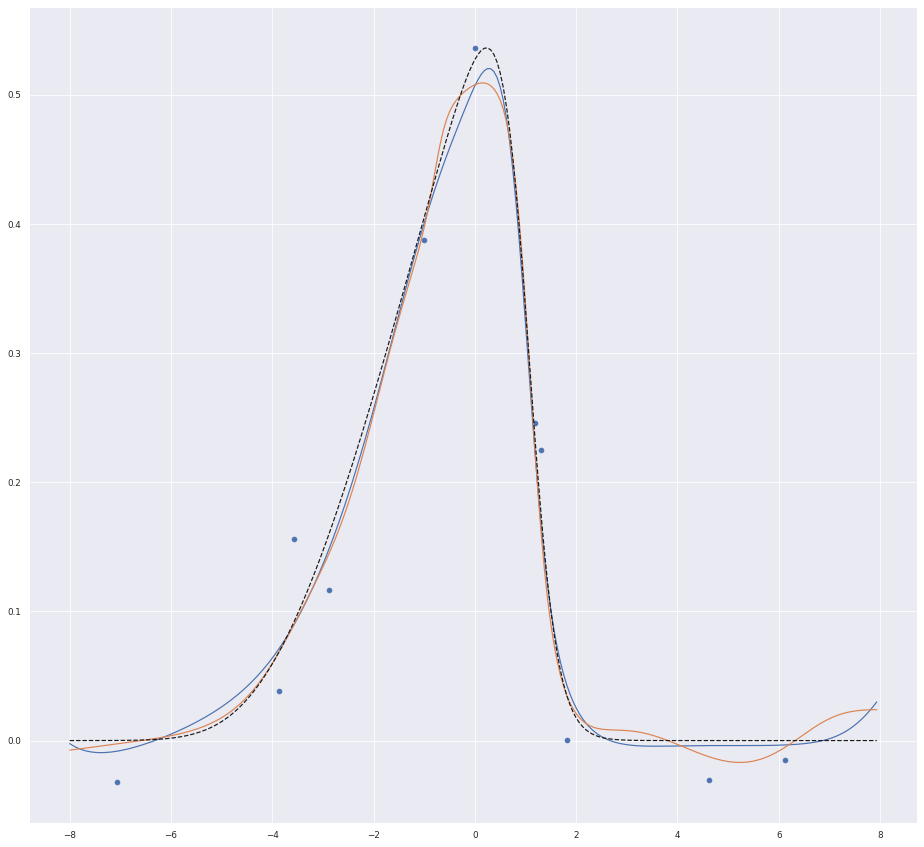

In [114]:
frame = 50
factor = 5

used_idx = np.where(X[idx, 0][:number_of_samples] ==data['t'][0, frame])[0]
c_used = y_noisy[idx][:number_of_samples][used_idx]
x_used = X[idx, 1][:number_of_samples][used_idx]

sort_idx = np.argsort(x_used)
c_used = c_used[sort_idx]
x_used = x_used[sort_idx]

plt.figure(figsize=(7*factor, 3*factor))

plt.subplot(121)
plt.scatter(x_used, c_used)
plt.plot(data['x'][:, 50], c_inferred_deepmod[:, frame])
plt.plot(data['x'][:, 50], c_inferred_MSE[:, frame])
plt.plot(data['x'][:, 50], np.real(data['u'])[:, frame], 'k--')


array([ 8,  1,  6,  0,  4, 10,  9,  7,  2,  5,  3])